### Library Import

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.utils import resample
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

### Data Load

In [2]:
# 파일 호출
data_path: str = "/Users/kimminji/Downloads/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 리스트로 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 38.74it/s]


### EDA (Explanatory Data Analysis)

In [4]:
eda_df = df.loc[df["_type"] == "train"] #

# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_open-interest_ftx_all_symbol_open_interest                100.0
hourly_market-data_open-interest_okx_open_interest                           100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations              100.0
hourly_market-data_liquidations_okex_btc_usd_long_liquidations_usd           100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations_usd          100.0
                                                                             ...  
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio      0.0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio          0.0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio           0.0
target                                                                         0.0
hourly_market-data_open-interest_htx_global_btc_usdt_open_interest             0.0
Length: 255, dtype: float64

In [5]:
# 몇 개 컬럼으로 EDA 예제
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_network-data_blockreward_blockreward":"blockreward",
}
# 추출후 단순화를 위해 rename
eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)

In [6]:
# 타겟 레이블 분포
eda_df["target"].value_counts()/len(eda_df)

target
2.0    0.419064
1.0    0.404566
3.0    0.091895
0.0    0.084475
Name: count, dtype: float64

In [7]:
# 타겟 값 별로 변수의 평균 파익
bar_df = eda_df.groupby("target").agg({
    "coinbase_premium_gap" : "mean",
    "long_liquidations" : "mean",
    "short_liquidations" : "mean",
    "buy_volume" : "mean",
    "sell_volume" : "mean",
}).reset_index()
bar_df

# 극단적인 경우, 즉 target 0, 3에서 평균적으로 coinbase_premium_gap, short_liquidations, buy_volume, sell_volume 값이 커짐

,target,coinbase_premium_gap,long_liquidations,short_liquidations,buy_volume,sell_volume
0,0.0,11.618797,34.306873,35.351660,4.046126e+08,4.037655e+08
1,1.0,5.919164,15.403795,17.878903,2.416815e+08,2.378602e+08
2,2.0,6.234038,20.308427,15.901697,2.380949e+08,2.442232e+08
3,3.0,13.476845,45.540121,37.819832,4.306805e+08,4.376228e+08


In [8]:
# 보다 관계를 명확히 파악하기 위해 barplot을 이용한 시각화 코드 작성
fig: go.Figure = make_subplots(
    rows=3,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
        "target distribution",
        "coinbase_premium_gap",
        "long_liquidations",
        "short_liquidations",
        "buy_volume",
        "sell_volume",
    ),
)
_target_disrtibution = eda_df["target"].value_counts() / len(eda_df)
fig.add_trace(
    go.Bar(
        x=_target_disrtibution.index, 
        y=_target_disrtibution,
    ), row=1, col=1
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["coinbase_premium_gap"]), row=1, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["long_liquidations"]), row=2, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["short_liquidations"]), row=2, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["buy_volume"]), row=3, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["sell_volume"]), row=3, col=2)
fig.update_layout(title_text="Target statistics", showlegend=False)
fig.update_xaxes(title_text="Target", row=3)
fig.show()

**위 그림으로부터 파악한 사실**

- target의 값 [0, 3]과 [1, 2]는 설명변수의 평균이 다르기 때문에 모델이 구분할 수 있을 것으로 추측
- 그러나, 각 target의 값 별로는 주어진 변수만으로 구별이 어려울 것으로 판단, 따라서 추가적인 feature engineering이 필요 

**가설**
1. long 포지션, short 포지션의 청산량의 차이가 가격 변동에 영향을 줄 것이다.
2. buy 거래량, sell 거래량의 차이가 가격 변동에 영향을 줄 것이다.

In [9]:
# liquidation, volume 으로 차이를 새로 생성하여 target 변수와의 관계 확인
eda_df = eda_df.assign(
    liquidation_diff=eda_df["long_liquidations"] - eda_df["short_liquidations"],
    volume_diff=eda_df["buy_volume"] - eda_df["sell_volume"],
)
bar_df = eda_df.groupby("target").agg({
    "liquidation_diff" : "mean", 
    "volume_diff" : "mean", 
}).reset_index()
bar_df # target 별로 liquidation diff, volume diff 가 각각 평균적으로 양의 관계, 음의 관계를 갖고 있음을 확인

,target,liquidation_diff,volume_diff
0,0.0,-1.044786,8.470791e+05
1,1.0,-2.475109,3.821241e+06
2,2.0,4.406731,-6.128251e+06
3,3.0,7.720289,-6.942215e+06


In [10]:
# 보다 관계를 명확히 파악하기 위해 barplot을 이용한 시각화 코드 작성
fig: go.Figure = make_subplots(
    rows=1,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
        "liquidation_diff",
        "volume_diff",
    ),
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["liquidation_diff"]), row=1, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["volume_diff"]), row=1, col=2)
fig.update_xaxes(title_text="Target")
fig.update_layout(title_text="Target statistics", showlegend=False)
fig.show()


**위 그림으로부터 파악한 사실**
- 가격 변동량이 클 때, 청산량의 차이 (long 청산 - short 청산)가 평균적으로 크다.
- 가격 변동량이 클 때, 거래량의 차이 (buy 거래량 - sell 거래량)가 평균적으로 작아진다.

따라서, 해당변수의 도입이 모델에 유의미한 영향을 줄 것이라 판단


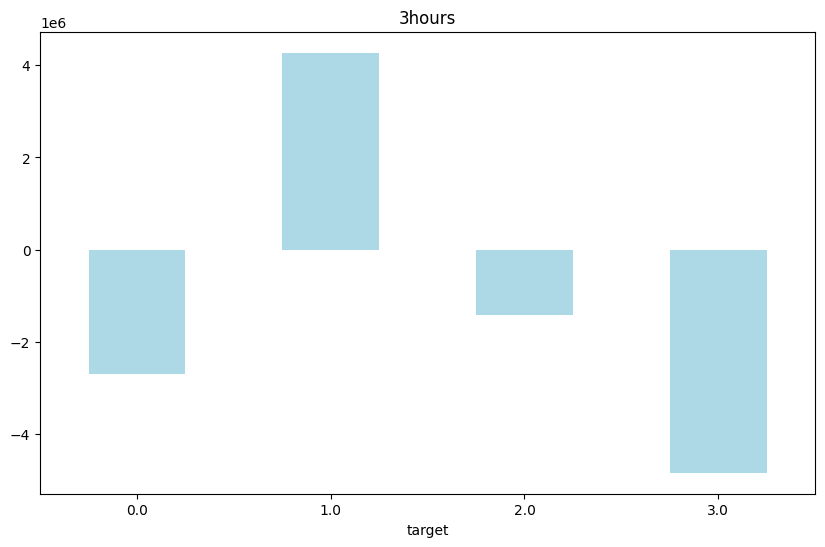

In [11]:
# 이동 평균 계산 (여기서는 3시간 이동 평균 예시)
eda_df['open_interest_ma_3'] = eda_df['open_interest'].rolling(window=3).mean()

# 이동 평균과 현재 open interest의 차이 계산
eda_df['open_interest_diff_ma_3'] = eda_df['open_interest'] - eda_df['open_interest_ma_3']

# 타겟별 open_interest_diff_ma_3의 평균 계산
target_diff_ma_3_mean = eda_df.groupby('target')['open_interest_diff_ma_3'].mean()

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
target_diff_ma_3_mean.plot(kind='bar', color='lightblue')
plt.title("3hours")
plt.xticks(rotation=0)
plt.show()

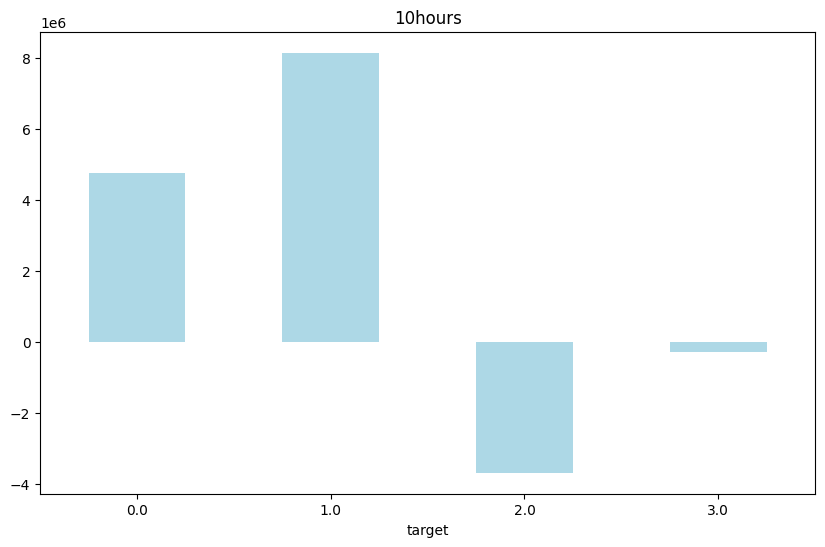

In [12]:
# 이동 평균 계산 (여기서는 3시간 이동 평균 예시)
eda_df['open_interest_ma_10'] = eda_df['open_interest'].rolling(window=10).mean()

# 이동 평균과 현재 open interest의 차이 계산
eda_df['open_interest_diff_ma_10'] = eda_df['open_interest'] - eda_df['open_interest_ma_10']

# 타겟별 open_interest_diff_ma_3의 평균 계산
target_diff_ma_10_mean = eda_df.groupby('target')['open_interest_diff_ma_10'].mean()

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
target_diff_ma_10_mean.plot(kind='bar', color='lightblue')
plt.title("10hours")
plt.xticks(rotation=0)
plt.show()

위 그림으로 파악했을 때
3시간 이동평균과의 차이와 10시간 이동평균 차이가 다른 분포를 보임

일단 이동평균과의 변화량을 구하면 1과 2를 구분하는데 유의미해보임


### Feature engineering

blockreward 변수 추가 

In [13]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    "hourly_network-data_blockreward_blockreward":"blockreward", #추가
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 20)

In [14]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

### shift 추가

In [15]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 4시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1,  4)]
)

#### rolling reature 추가

단기간의 변동성을 알기위해 3시간 이동평균 추가

In [16]:
def rolling_feature(df: pd.DataFrame, conti_cols: List[str], window_size: int) -> List[pd.Series]:
    """
    연속형 변수의 rolling feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        window_size (int): rolling window size
    Return:
        List[pd.Series]
    """
    df_rolling_list = [
        df[conti_col].rolling(window=window_size).mean().rename(f"{conti_col}_rolling_mean_{window_size}")
        for conti_col in conti_cols
    ]
    return df_rolling_list

rolling_list = rolling_feature(df=df, conti_cols=conti_cols, window_size=3)

#### ema 추가 

최근 변화에 더 많은 가중치를 주는 지수 이동 평균 추가

In [17]:
def ema_feature(df: pd.DataFrame, conti_cols: List[str], span: int) -> List[pd.Series]:
    """
    연속형 변수의 지수 이동 평균(EMA) 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        span (int): EMA의 span (기간)
    Return:
        List[pd.Series]: 각 연속형 변수의 EMA 피처 리스트
    """
    df_ema_list = [
        df[conti_col].ewm(span=span, adjust=False).mean().rename(f"{conti_col}_ema_{span}")
        for conti_col in conti_cols
    ]
    return df_ema_list
# EMA span 3으로 EMA feature 생성
ema_list = ema_feature(df=df, conti_cols=conti_cols, span=3)



In [18]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)
df = pd.concat([df, pd.concat(rolling_list, axis=1)], axis=1)
df = pd.concat([df, pd.concat(ema_list, axis=1)], axis=1)

### 이동평균과 현재값 차이 

이동평균값과의 차이를 통해 단기적인 변동성 측정

In [19]:
# 이동 평균 계산 
df['open_interest_rolling_mean_10'] = df['open_interest'].rolling(window=10).mean()

# 이동 평균과 현재 open interest의 차이 계산
df['open_interest_diff_10'] = df['open_interest'] - df['open_interest_rolling_mean_10']

In [20]:
df['open_interest_diff_3'] = df['open_interest'] - df['open_interest_rolling_mean_3']
df['blockreward_diff_3'] = df['blockreward'] - df['blockreward_rolling_mean_3']

In [21]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training XGB (하이퍼파라미터 튜닝)

시계열 데이터 특성에 맞게 과거 데이터로 학습하고 그 다음 데이터로 검증하는 교차검증 방식을 사용함

In [22]:
# 학습 데이터 준비
X = train_df.drop(["target", "ID"], axis=1)
y = train_df["target"].astype(int)

# Walk-forward validation을 위한 TimeSeriesSplit 설정
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# 결과를 저장할 리스트
accuracies = []
aurocs = []
conf_matrices = []


# XGBoost 하이퍼파라미터 설정
params = {
    "booster": "gbtree",
    "objective": "multi:softprob",  # 다중 클래스 분류
    "eval_metric": "mlogloss",      # 다중 클래스 로그 손실
    "num_class": 4,
    "eta": 0.012894918529898103,                    # 학습률
    "max_depth": 3,
    "min_child_weight": 9,
    "subsample":0.6049091029038681,
    "colsample_bytree": 0.9049920210888682,
    "lambda": 0.10434132982622774,
    "alpha": 0.8925541390708353,
    "seed": 42,
}


# Walk-forward validation with TimeSeriesSplit
for train_index, valid_index in tscv.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # XGBoost DMatrix 생성
    train_data = xgb.DMatrix(X_train, label=y_train)
    valid_data = xgb.DMatrix(X_valid, label=y_valid)
    
    # XGBoost 모델 학습
    xgb_model = xgb.train(
        params=params,
        dtrain=train_data,
        num_boost_round=80,
        evals=[(valid_data, "validation")],
        early_stopping_rounds=3,
        verbose_eval=False,
    )
    
    # 검증 데이터로 예측
    y_valid_pred = xgb_model.predict(valid_data)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    
    # 성능 평가
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    conf_matrix = confusion_matrix(y_valid, y_valid_pred_class)
    
    # 결과 저장
    accuracies.append(accuracy)
    aurocs.append(auroc)
    conf_matrices.append(conf_matrix)

# Walk-forward 결과 평균 계산
mean_accuracy = np.mean(accuracies)
mean_auroc = np.mean(aurocs)

# Confusion matrix 합산
total_conf_matrix = np.sum(conf_matrices, axis=0)

print(f"Walk-forward 검증 평균 Accuracy: {mean_accuracy}")
print(f"Walk-forward 검증 평균 AUROC: {mean_auroc}")

Walk-forward 검증 평균 Accuracy: 0.44191780821917803
Walk-forward 검증 평균 AUROC: 0.5868742559593565


In [23]:
total_conf_matrix 

array([[   5,  259,  375,    2],
       [   8, 1548, 1381,    1],
       [  10, 1352, 1672,    2],
       [   2,  304,  378,    1]])

In [25]:
# 각 클래스별 정답률 계산
class_accuracies = []

for i in range(len(total_conf_matrix)):
    correct_predictions = total_conf_matrix[i, i]  # 대각선 값 (정답 개수)
    total_predictions = np.sum(total_conf_matrix[i, :])  # 해당 행의 전체 값 (전체 예측 개수)
    accuracy = correct_predictions / total_predictions
    class_accuracies.append(accuracy)

# 결과 출력
for i, acc in enumerate(class_accuracies):
    print(f"Class {i} Accuracy: {acc:.4f}")

Class 0 Accuracy: 0.0078
Class 1 Accuracy: 0.5269
Class 2 Accuracy: 0.5507
Class 3 Accuracy: 0.0015


In [26]:
from sklearn.ensemble import RandomForestClassifier

# 특성과 타겟 변수 준비
X = train_df.drop(columns=['target','ID'])
y = train_df['target']

# RandomForest 모델 학습
rf = RandomForestClassifier()
rf.fit(X, y)

# 중요 변수 출력
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = sorted(zip(importances, feature_names), reverse=True)

In [27]:
feature_importances[:]

[(0.010296407729927176, 'open_interest_diff_3'),
 (0.010191531474544255, 'sell_volume'),
 (0.009647009683783443, 'sell_volume_ema_3'),
 (0.009623595100756, 'open_interest_diff_10'),
 (0.009418515669788125, 'active_count_3'),
 (0.009370648600890742, 'buy_volume'),
 (0.009349498386779294, 'blockreward_diff_3'),
 (0.009209216023563907, 'buy_volume_ema_3'),
 (0.009195508287176291, 'receiver_count_3'),
 (0.009078135889440661, 'receiver_count_2'),
 (0.009068771369827979, 'sell_volume_rolling_mean_3'),
 (0.008992973651602822, 'blockreward_1'),
 (0.008929121745263214, 'blockreward_3'),
 (0.008832515311264605, 'blockreward_rolling_mean_3'),
 (0.008738459700766995, 'receiver_count_1'),
 (0.008715953452110646, 'sender_count_3'),
 (0.008638434298533042, 'active_count_1'),
 (0.008613209957300652, 'blockreward_2'),
 (0.008556383676445225, 'liquidation_usd_diff'),
 (0.008533710223564927, 'active_count_2'),
 (0.008524807914167928, 'sender_count_2'),
 (0.00852348569708008, 'receiver_count'),
 (0.008465

------

In [28]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)
train_data = xgb.DMatrix(x_train, label=y_train)
# XGBoost 모델 학습
lgb_model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=80,  
    verbose_eval=False      
)

### Inference

In [29]:
# test 데이터 준비
test_data = xgb.DMatrix(test_df.drop(["target", "ID"], axis=1))

# xgb predict
y_test_pred = xgb_model.predict(test_data)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# 예측 결과 출력
print(y_test_pred_class)

[2 1 2 ... 1 1 1]


### Output File Save

In [37]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output_last.csv", index=False)